<a href="https://colab.research.google.com/github/Ruanvans/GAN-time-series-implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following code will serve as the GAN network employed in my disseratation**

**Ruan van Schalkwyk**                                                            
**6459265**

**Supervisor: Yoachu Jin** 

**University of Surrey Computer Science** 


# **Necessary libraries and tools**

In [0]:
%pip install keras-tcn

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=2b14ec3916d9fc347cb306c73ff02879afc23a8354c8179643b2045dada79507
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [0]:
#libraries and tools necessary to import and visualize data
from google.colab import files
import pandas as pd
import requests 
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot

#libraries to create the models and visualize models
from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils.vis_utils import plot_model
import numpy as np
from numpy import hstack 
from numpy import zeros 
from numpy import ones 
from numpy.random import randn 
from numpy.random import rand
import random
#from tcn import TCN, tcn_full_summary

#libraries needed to create the Wasserstein GAN 
from keras import backend
from keras.optimizers import RMSprop
from keras.constraints import Constraint
from keras.initializers import RandomNormal

# **Data Collection**

The below cells of code are used to retrieve the data used within the project from the AlphaVantage API. The first cell works directly with the API and the second cell is used to format the data into the correct format (csv file) and then downloads the data so that it can be cleaned for further use

In [0]:
Key = 'WS42XHAOBGP40QEM'
sym= 'AAPL'

fname = 'daily' + sym +'.csv'

if not os.path.isfile(fname):
  v = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + sym + "&apikey=" + Key + "&outputsize=full&datatype=csv").read()
  with open(fname, 'wb') as f:
    f.write(v)

In [0]:
df = pd.read_csv(fname)
df = pd.DataFrame(df)
df.to_csv('Apple.csv')
files.download('Apple.csv')
df

,timestamp,open,high,low,close,volume
0,2020-05-11,308.10,317.05,307.24,315.01,36486561
1,2020-05-08,305.64,310.35,304.29,310.13,33511985
2,2020-05-07,303.22,305.17,301.97,303.74,28803764
3,2020-05-06,300.46,303.24,298.87,300.63,35583438
4,2020-05-05,295.06,301.00,294.46,297.56,36937795
...,...,...,...,...,...,...
5027,2000-05-16,104.52,109.06,102.75,105.69,3932600
5028,2000-05-15,108.06,108.06,100.12,101.00,6061900
5029,2000-05-12,106.00,110.50,104.77,107.62,2740300
5030,2000-05-11,101.37,104.25,99.00,102.81,4462000


# **Data preprocessign**

Below cell provides convenience when uploading the data as it is faster to upload a zip file with all the cleaned data to google colab than to upload individual files. 

In [0]:
!unzip 'final_data.zip'

Archive:  final_data.zip
  inflating: boeing.csv              
  inflating: Intercontinental.csv    
  inflating: JPMorgan.csv            
  inflating: Microsoft.csv           
  inflating: pfizer.csv              


importation of the data from the cleaned csv files

In [0]:
intercontinental = pd.read_csv('Intercontinental.csv', parse_dates=True, index_col=0)
boeing = pd.read_csv('boeing.csv', parse_dates=True, index_col=0)
jpmorgan = pd.read_csv('JPMorgan.csv', parse_dates=True, index_col=0)
microsoft = pd.read_csv('Microsoft.csv', parse_dates=True, index_col=0)
pfizer = pd.read_csv('pfizer.csv', parse_dates=True, index_col=0)

# **Visualisation of the chosen stocks**

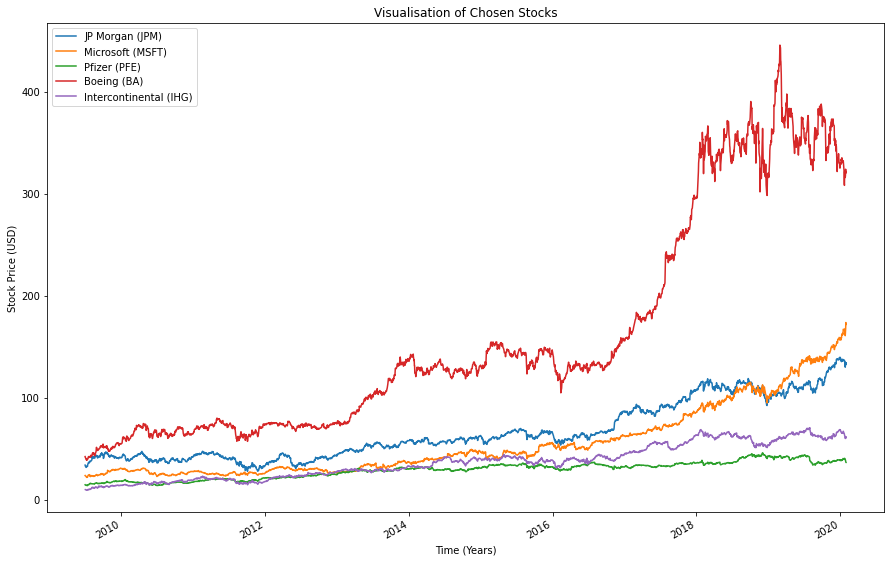

In [0]:
Intercontinental = intercontinental['open']
Boeing = boeing['open']
JPmorgan = jpmorgan['open']
Microsoft = microsoft['open']
Pfizer = pfizer['open']

plt.figure(figsize=(15,10))
JPmorgan.plot(label = 'JP Morgan (JPM)')
Microsoft.plot(label = 'Microsoft (MSFT)')
Pfizer.plot(label = 'Pfizer (PFE)')
Boeing.plot(label= 'Boeing (BA)')
Intercontinental.plot(label = 'Intercontinental (IHG)')
plt.title(label = 'Visualisation of Chosen Stocks')
plt.legend(loc='upper left')
plt.ylabel(ylabel= 'Stock Price (USD)')
plt.xlabel(xlabel= 'Time (Years)')
plt.savefig('stocks.png', bbox_inches ='tight')
files.download('stocks.png')
plt.show()

# **Vanilla GAN**

## **Creating the architecture**

In [0]:
def Generator_method(latent_space, num_outputs=2):  
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_space))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  return model

#latent_space = 10
#model = Generator(latent_space)
#model.summary()
#plot_model(model, to_file='generator_structure.png', show_shapes=True, show_layer_names=True)

In [0]:
def Discriminator_method(num_inputs=2): 
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#model = Discriminator()
#model.summary()
#plot_model(model, to_file='discriminator_structure.png', show_shapes=True, show_layer_names=True)

In [0]:
def GAN_method(Generator, Discriminator): 
  Discriminator_model.trainable = False
  model = Sequential()
  model.add(Generator_model)
  model.add(Discriminator_model)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

#latent_space = 10
#Generator_model = Generator(latent_space)
#Discriminator_model = Discriminator()

#model = GAN(Generator_model, Discriminator_model)
#model.summary()
#plot_model(model, to_file='gan_structure.png', show_shapes=True, show_layer_names=True)

**The three methods below are used to create examples to train and test the GAN architectures**

In [0]:
"""
this method is used when stress testing the gan on various mathematical functions
the value of of x_func can be replaced with any function to test the working of
the GAN architecture. The examples created here are used to train the discriminator 
to recognise what real examples look like
"""
def real_examples(n): 
#this line creates the random numbers that will be used within the x_func variable
  X_var = -2.5+(2.5-(-2.5))*rand(1,n)
  #X_var = np.arange(0, n*0.1,0.1)
#the x_func variable is used to model the mathematical function we wish to generate 
  X_func = X_var * X_var * X_var
  #X_func = (X_var + 3)*((X_var -2)**2)*((X_var+1)**3)
  #X_func = np.sin(X_var)
#the variables have to be reshaped so that they may be stacked into an array 
  X_var = X_var.reshape(n,1)
  X_func = X_func.reshape(n,1)
#hstack is used to ensure that the x_var corresponds to x_func 
  X = hstack((X_var,X_func))
#we generate labels for the real examples in the form of ones
  y = ones((n,1))
  return X,y
"""
the method below creates the points in latent space that will serve as the input 
to the generator model. The literature on GANs suggest that the best type of input 
for a GAN model's generator are random points from a gaussian distribution. 
"""
def latent_points(latent, n):
#we use randn here as it returns random variables from a normal gaussian distribution 
  input_var = randn(latent*n)
  input_var = input_var.reshape(n,latent)
  return input_var
"""
we use the generator in this method to construct fake examples of the data made 
up from random generations. it takes in the generator model and latent points to
generate the fake examples. 
"""
def fake_examples(gen, latent,n):
  input_var = latent_points(latent, n)
  X = gen.predict(input_var)
  y = zeros((n,1))
  return X,y

In [0]:
"""
this method is used to systematically visualize the performance of the GAN model 
by evaluating the accuracy of the discriminator on both real and fake examples 
it also visualizes the generated samples produced by the generator along with 
the real samples. 
"""
def snapshot(epoch, gen, dis, latent, n=100):
#generate real samples and their corresponding labels 
  example_real, label_real = real_examples(n)
#determine the accuracy of the discriminator by using it to evaluate on the real samples generated above
  _, real_accuracy = dis.evaluate(example_real, label_real, verbose=0)
#generate fake samples and their corresponding labels 
  example_fake, label_fake = fake_examples(gen, latent, n)
#determine the accuracy of the discriminator by using it to evaluate on the fake samples generated above
  _, fake_accuracy = dis.evaluate(example_fake, label_fake, verbose=0)
#creation of the plot to visualize the performance and print the accuracies
  print("epoch: " , epoch +1, "accuracy detecting a fake: ", fake_accuracy, "accuracy detecting a real example: ", real_accuracy)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
"""
creates a visualization of the loss of the discriminator on both real and fake 
samples as well as the loss of the gan model
"""
def loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake):
  plt.plot(gan_loss, color='red',label='GAN loss')
  plt.plot(discriminator_loss_real, color='green', label='Discriminator Loss Real Samples')
  plt.plot(discriminator_loss_fake, color='blue', label='Discriminator Loss Fake Samples')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss Value')
  plt.legend(loc='upper right')
  plt.savefig('Loss visualisation')
  plt.show()

In [0]:
def gen_method(latent, num_outputs=2):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  return model

def dis_method(num_inputs=2):
  
  model = Sequential()
  
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  """
  return model

def gan_method(gen, dis):
  dis.trainable =False
  model = Sequential()
  model.add(gen)
  model.add(dis)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [0]:
def training_method(gen_architecture, dis_architecture, gan_architecture, latent, epochs=50000, batch_size=128, snapshot_value=5000):
  
  update = int(batch_size/2)
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()

  for i in range(epochs):

    example_real, label_real = real_examples(update)
    example_fake, label_fake = fake_examples(gen_architecture, latent, update)

    discriminator_history_real = dis_architecture.train_on_batch(example_real, label_real)
    discriminator_history_fake = dis_architecture.train_on_batch(example_fake, label_fake)

    discriminator_loss_real.append(np.mean(discriminator_history_real))
    discriminator_loss_fake.append(np.mean(discriminator_history_fake))

    gan_input = latent_points(latent, batch_size)
    gan_labels = ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      snapshot(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1 accuracy detecting a fake:  0.0 accuracy detecting a real example:  1.0


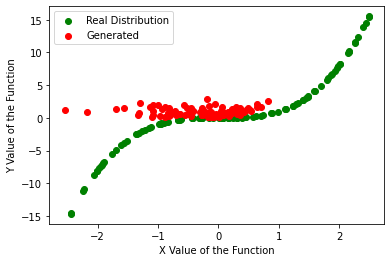

epoch:  5000 accuracy detecting a fake:  0.5699999928474426 accuracy detecting a real example:  0.800000011920929


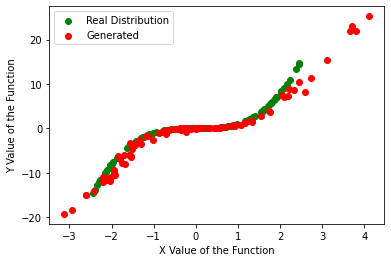

epoch:  10000 accuracy detecting a fake:  0.6200000047683716 accuracy detecting a real example:  0.7699999809265137


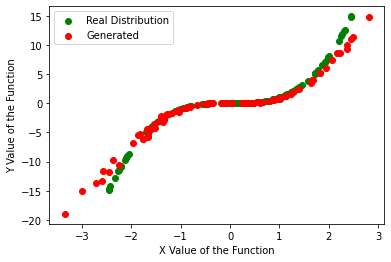

epoch:  15000 accuracy detecting a fake:  0.6800000071525574 accuracy detecting a real example:  0.550000011920929


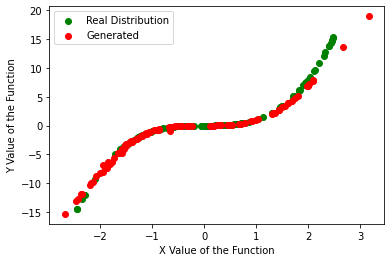

epoch:  20000 accuracy detecting a fake:  0.6299999952316284 accuracy detecting a real example:  0.6800000071525574


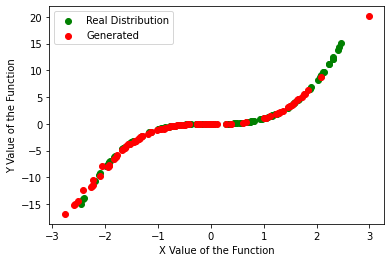

KeyboardInterrupt: ignored

In [31]:
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)

training_method(gen, dis, gan_architecture, latent)

# **Wasserstein GAN**

In [0]:
def Wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

  

In [0]:
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


In [0]:
def Wasserstein_gen_method(latent, num_outputs=2):
  initializer = RandomNormal(stddev=0.02)
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  """
  return model

def Wasserstein_dis_method(num_inputs=2):
  const = ClipConstraint(0.2)
  initializer = RandomNormal(stddev=0.02)
  model = Sequential()
  
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', kernel_constraint = const, input_dim=num_inputs))
  model.add(Dense(15, activation='relu',  kernel_constraint = const))
  model.add(Dense(10, activation='relu',  kernel_constraint = const))
  model.add(Dense(1, activation='linear'))
  opt = RMSprop(lr=0.000075)
  model.compile(loss=Wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  """
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  """
  return model

def Wasserstein_gan_method(gen, dis):
  dis.trainable =False
  model = Sequential()
  model.add(gen)
  model.add(dis)
  opt = RMSprop(lr=0.000075)
  model.compile(loss=Wasserstein_loss, optimizer=opt)
  return model

In [0]:
"""
this method is used when stress testing the gan on various mathematical functions
the value of of x_func can be replaced with any function to test the working of
the GAN architecture. The examples created here are used to train the discriminator 
to recognise what real examples look like
"""
def Wasserstein_real_examples(n): 
#this line creates the random numbers that will be used within the x_func variable
  X_var = -2.5+(2.5-(-2.5))*rand(1,n)
  #X_var = np.arange(0, n*0.1,0.1)
#the x_func variable is used to model the mathematical function we wish to generate 
  X_func = X_var * X_var * X_var
  #X_func = (X_var + 3)*((X_var -2)**2)*((X_var+1)**3)
  #X_func = np.sin(X_var)
#the variables have to be reshaped so that they may be stacked into an array 
  X_var = X_var.reshape(n,1)
  X_func = X_func.reshape(n,1)
#hstack is used to ensure that the x_var corresponds to x_func 
  X = hstack((X_var,X_func))
#we generate labels for the real examples in the form of ones
  y = -ones((n,1))
  return X,y
"""
the method below creates the points in latent space that will serve as the input 
to the generator model. The literature on GANs suggest that the best type of input 
for a GAN model's generator are random points from a gaussian distribution. 
"""
def Wasserstein_latent_points(latent, n):
#we use randn here as it returns random variables from a normal gaussian distribution 
  input_var = randn(latent*n)
  input_var = input_var.reshape(n,latent)
  return input_var
"""
we use 
"""
def Wasserstein_fake_examples(gen, latent,n):
  input_var = Wasserstein_latent_points(latent, n)
  X = gen.predict(input_var)
  y = ones((n,1))
  return X,y

In [0]:
def Wasserstein_snapshot(epoch, gen, dis, latent, n=100):
  example_real, label_real = Wasserstein_real_examples(n)
  _, real_accuracy = dis.evaluate(example_real, label_real, verbose=0)
  example_fake, label_fake = Wasserstein_fake_examples(gen, latent, n)
  _, fake_accuracy = dis.evaluate(example_fake, label_fake, verbose=0)

  print("epoch: " , epoch +1, "accuracy detecting a fake: ", fake_accuracy, "accuracy detecting a real example: ", real_accuracy)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.xlabel('X Value of the Function')
  plt.ylabel('Y Value of the Function')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
def Wasserstein_training_method(gen_architecture, dis_architecture, gan_architecture, latent, epochs=50000, discriminator_update=5, batch_size=128, snapshot_value=5000):
  
  update = int(batch_size/2)
  gan_loss , discriminator_loss_real, discriminator_loss_fake = list(), list(), list()

  for i in range(epochs):

    discriminator_loss_real_temp, discriminator_loss_fake_temp = list(), list()

    for _ in range(discriminator_update): 

      example_real, label_real = Wasserstein_real_examples(update)
      example_fake, label_fake = Wasserstein_fake_examples(gen_architecture, latent, update)

      discriminator_history_real_temp = dis_architecture.train_on_batch(example_real, label_real)
      discriminator_history_fake_temp = dis_architecture.train_on_batch(example_fake, label_fake)

      discriminator_loss_real_temp.append((discriminator_history_real_temp))
      discriminator_loss_fake_temp.append((discriminator_history_fake_temp))

    discriminator_loss_real.append(np.mean(discriminator_loss_real_temp))
    discriminator_loss_fake.append(np.mean(discriminator_loss_fake_temp))

    gan_input = Wasserstein_latent_points(latent, batch_size)
    gan_labels = -ones((batch_size,1))
    gan_history = gan_architecture.train_on_batch(gan_input, gan_labels)

    gan_loss.append(np.mean(gan_history))

    if ((i+1) == 1 or (i+1) % snapshot_value ==0):
      Wasserstein_snapshot(i,gen_architecture,dis_architecture,latent)

  loss_visualisation(gan_loss, discriminator_loss_real, discriminator_loss_fake)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  1 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


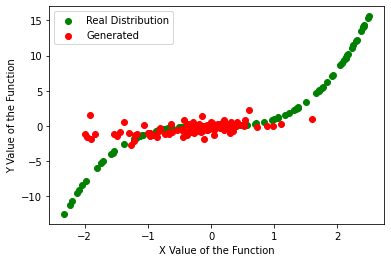

epoch:  5000 accuracy detecting a fake:  0.07999999821186066 accuracy detecting a real example:  0.029999999329447746


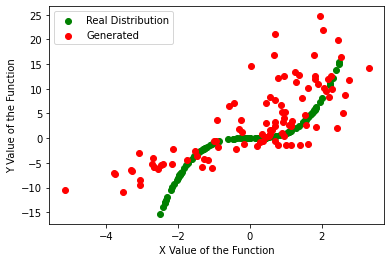

epoch:  10000 accuracy detecting a fake:  0.009999999776482582 accuracy detecting a real example:  0.009999999776482582


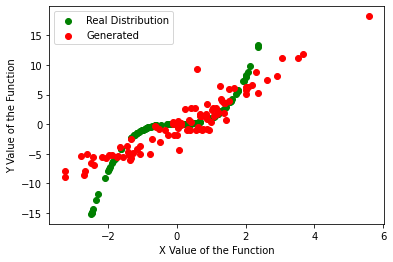

epoch:  15000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.019999999552965164


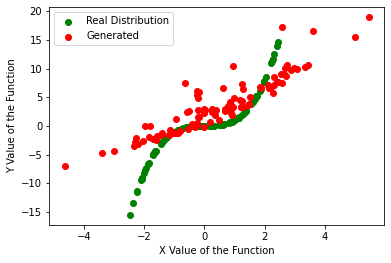

epoch:  20000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.029999999329447746


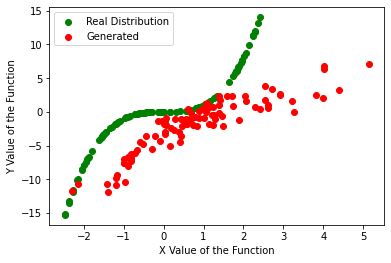

epoch:  25000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


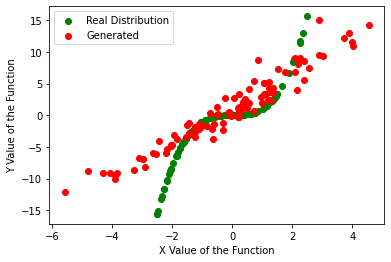

epoch:  30000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


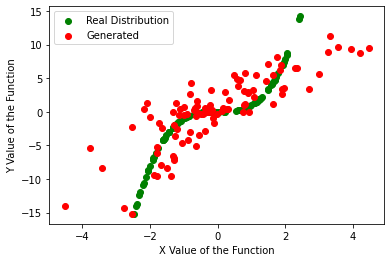

epoch:  35000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


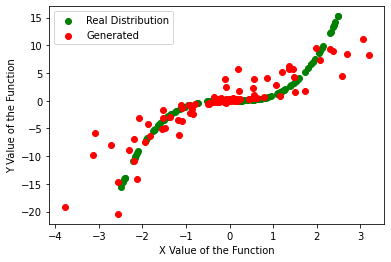

epoch:  40000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


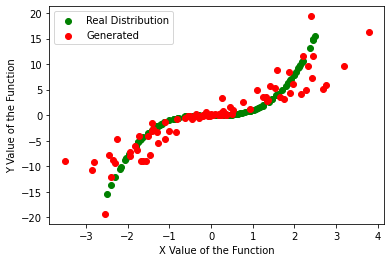

epoch:  45000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


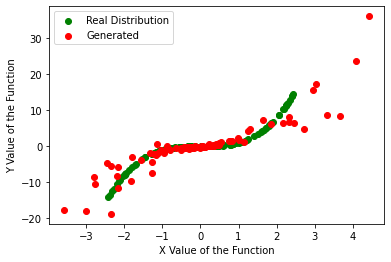

epoch:  50000 accuracy detecting a fake:  0.0 accuracy detecting a real example:  0.0


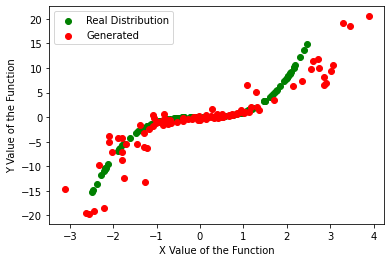

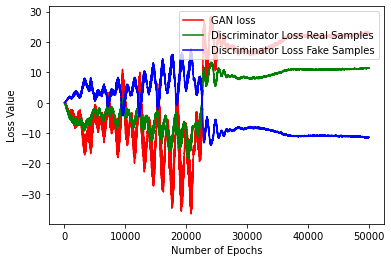

In [74]:
latent = 5
gen = Wasserstein_gen_method(latent)
dis = Wasserstein_dis_method()
gan_architecture = Wasserstein_gan_method(gen,dis)

Wasserstein_training_method(gen, dis, gan_architecture, latent)

# **Wasserstein GAN with gradient penalty**